In [1]:
import numpy as np
import pandas as pd
from plotnine import *

In this notebook, we check whether the peak intensities for the flares listed in `flare_data.parquet` match the GOES soft X-ray fluxes recorded at the peak times of those flares.

In [2]:
flare_data = pd.read_parquet("flare_data.parquet")
flare_data.reset_index(inplace=True, names="flare_id")
flare_data.head()

,flare_id,start time,end time,peak time,flare_class,peak_intensity,noaa_ar_5min,noaa_ar_5s,hg1,hg2,car1,car2,rtheta1,rtheta2,xy1,xy2,solar_p_angle,solar_radius
0,0,2010-01-01 06:02:00+00:00,2010-01-01 06:13:00+00:00,2010-01-01 06:09:00+00:00,B,1.100000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-01-01 12:00:00+00:00,2010-01-01 12:19:00+00:00,2010-01-01 12:09:00+00:00,B,2.700000e-07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2010-01-01 12:27:00+00:00,2010-01-01 13:09:00+00:00,2010-01-01 12:43:00+00:00,B,3.300000e-07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2010-01-01 15:58:00+00:00,2010-01-01 16:31:00+00:00,2010-01-01 16:20:00+00:00,B,2.500000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2010-01-01 18:20:00+00:00,2010-01-01 18:31:00+00:00,2010-01-01 18:27:00+00:00,B,1.300000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For each flare, we will obtain the fluxes recorded between the `start time` and the `end time`, so we only use flares with `end times` (see `process_flare_data.ipynb`). We will only need the columns listed below.

In [3]:
flare_data = flare_data.loc[flare_data["end time"].notna(), ["flare_id", "start time", "end time", "peak time", "peak_intensity"]]

We convert each flare record into a set of records, one for each time between the `start time` and the `end time`.

In [4]:
flare_data["time_range"] = flare_data.apply(lambda row: pd.date_range(start=row["start time"], end=row["end time"], freq="min"), axis=1)
flare_data = flare_data.explode("time_range", ignore_index=True).rename(columns={"time_range": "time"})
flare_data.drop(columns=["start time", "end time"], inplace=True)
flare_data.head()

,flare_id,peak time,peak_intensity,time
0,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:02:00+00:00
1,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:03:00+00:00
2,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:04:00+00:00
3,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:05:00+00:00
4,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:06:00+00:00


Load the flux data.

In [5]:
flux_data = pd.read_parquet("../xray_fluxes/data/processed/1m_data.parquet")
flux_data.head()

,time,satellite_secondary,satellite_primary,flux_secondary,flux_primary,good_data_secondary,good_data_primary,satellite,flux,good_data
0,1998-07-27 00:00:00+00:00,10,None,3.042857e-07,NaN,True,None,10,3.042857e-07,True
1,1998-07-27 00:01:00+00:00,10,None,3.000000e-07,NaN,True,None,10,3.000000e-07,True
2,1998-07-27 00:02:00+00:00,10,None,2.971429e-07,NaN,True,None,10,2.971429e-07,True
3,1998-07-27 00:03:00+00:00,10,None,2.985715e-07,NaN,True,None,10,2.985715e-07,True
4,1998-07-27 00:04:00+00:00,10,None,2.971429e-07,NaN,True,None,10,2.971429e-07,True


For each flare, for each time, we obtain the flux recorded at that time.

In [6]:
flare_flux_data = pd.merge(flare_data, flux_data[["time", "flux"]], how="left", on="time")
flare_flux_data.head()

,flare_id,peak time,peak_intensity,time,flux
0,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:02:00+00:00,7.581849e-08
1,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:03:00+00:00,7.654781e-08
2,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:04:00+00:00,7.918842e-08
3,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:05:00+00:00,8.006862e-08
4,0,2010-01-01 06:09:00+00:00,1.100000e-07,2010-01-01 06:06:00+00:00,8.675816e-08


For each flare, we retain its peak intensity and compute the maximum flux.

In [7]:
flare_max_fluxes = (
    flare_flux_data
    .groupby("flare_id")
    .agg(peak_intensity=("peak_intensity", "first"), max_flux=("flux", "max"))
    .reset_index()
)
flare_max_fluxes.head()

,flare_id,peak_intensity,max_flux
0,0,1.100000e-07,1.156875e-07
1,1,2.700000e-07,2.741912e-07
2,2,3.300000e-07,3.377629e-07
3,3,2.500000e-07,2.583727e-07
4,4,1.300000e-07,1.357729e-07


The scatterplot below is a plot of `max_flux` versus `peak_intensity`. On the green line, the two are equal. Most flares lie on that line; those that don't aren't too far away from it. Thus, the peak intensity closely matches the maximum flux.

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


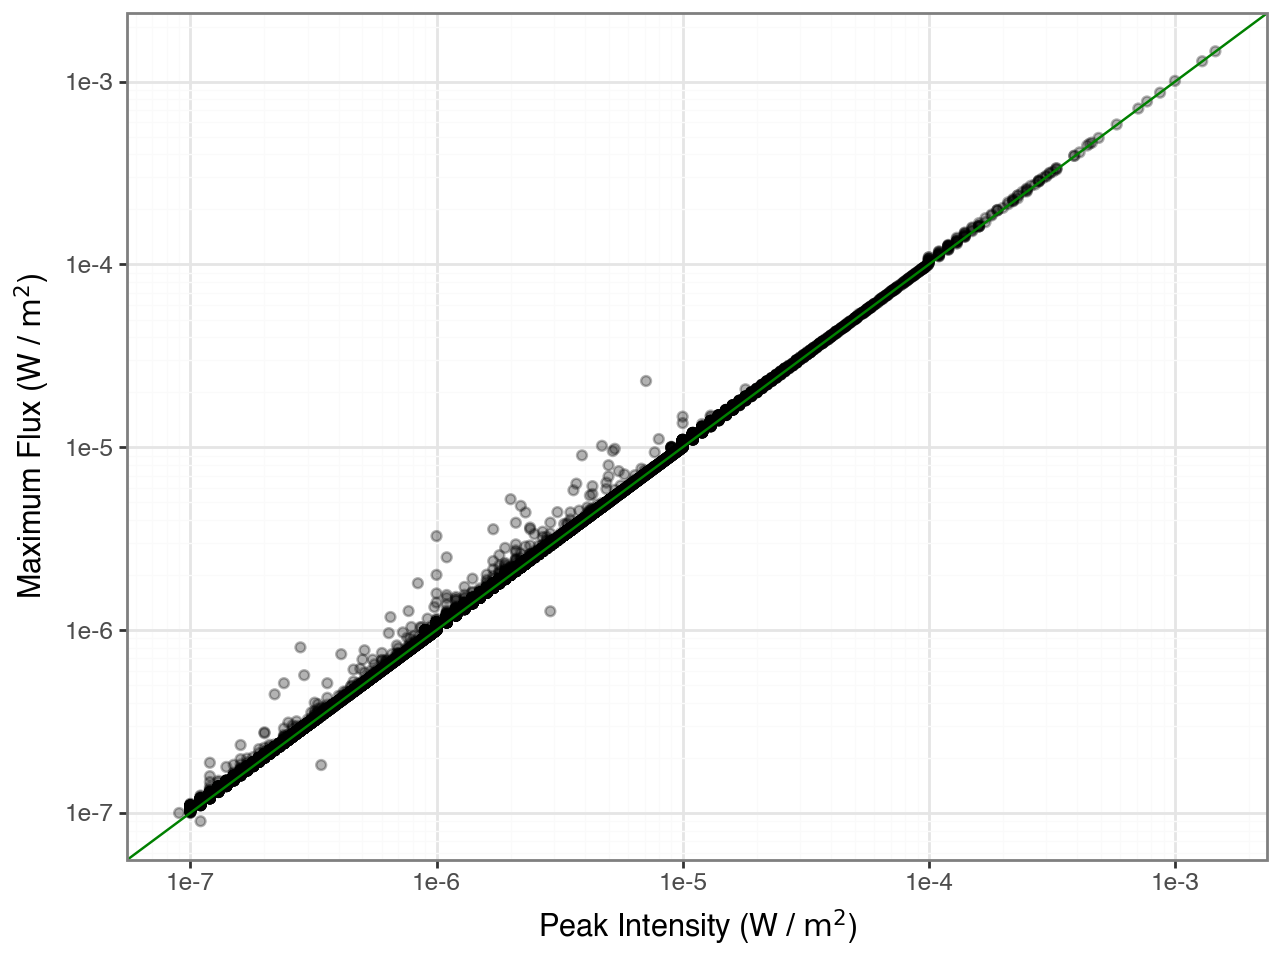

In [8]:
(
    ggplot(data=flare_max_fluxes, mapping=aes(x="peak_intensity", y="max_flux")) +
    geom_point(alpha=0.3) +
    geom_abline(slope=1, intercept=0, color="green") +
    scale_x_log10() +
    scale_y_log10() +
    labs(x=r"Peak Intensity (W / $\text{m}^2$)", y =r"Maximum Flux (W / $\text{m}^2$)") +
    theme_bw()
)

We can use the function below to compute the flare class for a given flux.

In [9]:
def get_flare_class(peak_intensity: float) -> str:
    thresholds = [10 ** i for i in range(-4, -9, -1)]
    flare_classes = ["X", "M", "C", "B", "A"]
    for threshold, flare_class in zip(thresholds, flare_classes):
        if peak_intensity >= threshold:
            return flare_class
    return np.nan

We compute the flare classes for the peak intensities and maximum fluxes.

In [10]:
flare_max_fluxes["peak_intensity_flare_class"] = flare_max_fluxes["peak_intensity"].map(get_flare_class)
flare_max_fluxes["max_flux_flare_class"] = flare_max_fluxes["max_flux"].map(get_flare_class)

The flare classes for the two quantities are virtually always the same.

In [11]:
(flare_max_fluxes["peak_intensity_flare_class"] == flare_max_fluxes["max_flux_flare_class"]).value_counts()

True     27276
False       18
Name: count, dtype: int64

Below are the flares for which the flare classes are different.

In [12]:
flare_max_fluxes[flare_max_fluxes["peak_intensity_flare_class"] != flare_max_fluxes["max_flux_flare_class"]]

,flare_id,peak_intensity,max_flux,peak_intensity_flare_class,max_flux_flare_class
425,484,1.200000e-07,NaN,B,NaN
485,561,1.100000e-07,9.004243e-08,B,A
570,667,1.600000e-07,NaN,B,NaN
2748,3148,8.000000e-06,1.109261e-05,C,M
4845,5551,8.600000e-07,1.037751e-06,B,C
5294,6069,9.900000e-07,1.009841e-06,B,C
5349,6130,4.700000e-06,1.019140e-05,C,M
7633,8713,6.500000e-07,1.178551e-06,B,C
7650,8732,7.700000e-07,1.271081e-06,B,C
9913,11282,7.100000e-06,2.304290e-05,C,M


We next compute the time of the maximum flux for each flare and the amount by which the `peak time` differs from it.

In [13]:
flare_max_times = flare_flux_data.groupby("flare_id")["peak time"].first().reset_index().set_index("flare_id", drop=False)
flare_max_times["max_time"] = flare_flux_data.groupby("flare_id")[["time", "flux"]].apply(lambda df: df["time"].iloc[df["flux"].argmax()])
flare_max_times.reset_index(drop=True, inplace=True)
flare_max_times["diff"] = (flare_max_times["peak time"] - flare_max_times["max_time"]).dt.total_seconds() / 60
flare_max_times["diff"] = flare_max_times["diff"].astype("int")
flare_max_times.head()

/var/folders/0j/7bxrsnld6539ckmfpj6bgs4w0000gs/T/ipykernel_47560/3220865501.py:2: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.


,flare_id,peak time,max_time,diff
0,0,2010-01-01 06:09:00+00:00,2010-01-01 06:09:00+00:00,0
1,1,2010-01-01 12:09:00+00:00,2010-01-01 12:09:00+00:00,0
2,2,2010-01-01 12:43:00+00:00,2010-01-01 12:43:00+00:00,0
3,3,2010-01-01 16:20:00+00:00,2010-01-01 16:20:00+00:00,0
4,4,2010-01-01 18:27:00+00:00,2010-01-01 18:27:00+00:00,0


For the vast majority of flares, there is no difference between the two times.

In [14]:
(flare_max_times["diff"] == 0).value_counts()

diff
True     26666
False      628
Name: count, dtype: int64

Among the flares for which there is a difference, the `peak time` typically precedes the time of the maximum flux by around five minutes.

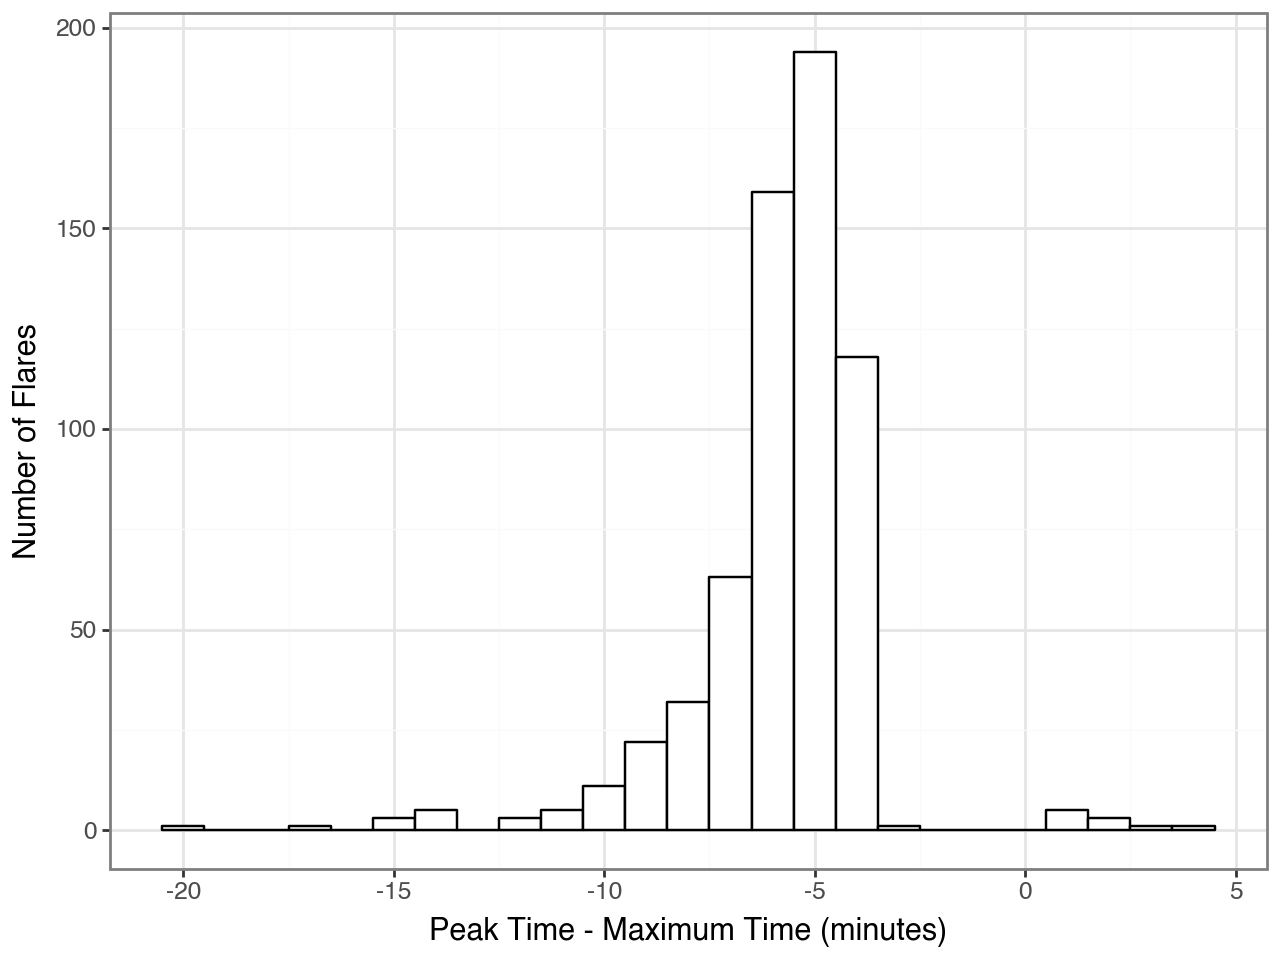

In [15]:
(
    ggplot(data=flare_max_times[flare_max_times["diff"] != 0], mapping=aes(x="diff")) +
    geom_histogram(binwidth=1, fill="white", color="black") +
    labs(x="Peak Time - Maximum Time (minutes)", y="Number of Flares") +
    theme_bw()
)

We will plot the fluxes for the flare with the biggest discrepancy between the two times.

In [16]:
biggest_diff_flare = flare_max_times.iloc[flare_max_times["diff"].abs().argmax()]
biggest_diff_flare

flare_id                         14555
peak time    2014-12-21 17:35:00+00:00
max_time     2014-12-21 17:55:00+00:00
diff                               -20
Name: 12758, dtype: object

The below plot shows the fluxes for the flare with the biggest discrepancy. The dashed line is at the `peak time` and the dotted line is at the time of the maximum flux. The fluxes at the two times differ by very little. However, the discontinuity at the time of the maximum flux is strange.

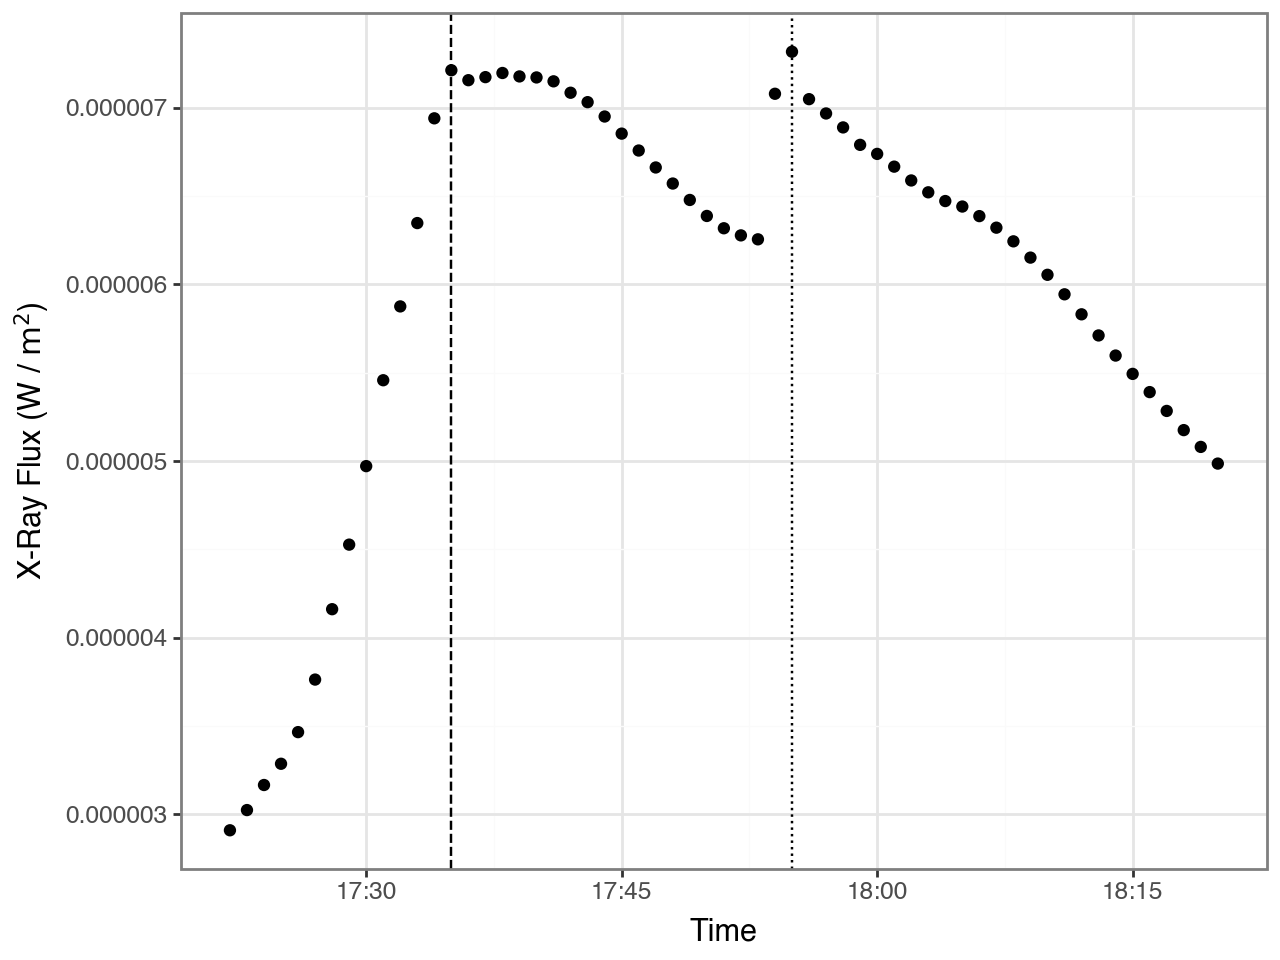

In [17]:
df = flare_flux_data[flare_flux_data["flare_id"] == biggest_diff_flare["flare_id"]].reset_index(drop=True)
(
    ggplot(data=df, mapping=aes(x="time", y="flux")) +
    geom_vline(xintercept=df.loc[0, "peak time"], linetype="dashed") +
    geom_vline(xintercept=biggest_diff_flare["max_time"], linetype="dotted") +
    geom_point() +
    scale_x_datetime(date_labels="%R") +
    labs(x="Time", y=r"X-Ray Flux (W / $\text{m}^2$)") +
    theme_bw()
)